In [1]:
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np

country = "Austria"
cut_date = "2020-07-01"
N = 9_000_000
T_split1 =  10 # WAS 35

n_iter = 50000     
proposal_scales = np.array([0.1,0.05,0.05,0.05,0.05,0.01,0.01,0.05,0.05,0.05,0.05,0.01,0.01,0.01,0.01])
start = np.array([0.2,0.1,0.5,0.2,0.2,0.01,0.01,0.2,0.2,0.2,0.2,0.01,0.01,0.01,0.01])
start2 = np.array([0.8,0.1,0.5,0.2,0.2,0.01,0.01,0.2,0.2,0.2,0.2,0.01,0.01,0.01,0.01])   # for second block
param_names = ['beta','rho','phi','k1','k2','l1','l2','k3','k4','k5','k6','l3','l4','l5','l6']

#caricamento
df = pd.read_csv("csv/dati.csv" )
df = df[df['country'] == country].copy()
df = df[df['survey_date'] <= cut_date].copy()
# interpolazione pct_mask
df['pct_mask_f'] = df['pct_mask'].interpolate(method='linear')
daily_cases_all_full = df['new_cases_smoothed'].to_numpy(dtype=float) / N
mask_all_full = df['pct_mask_f'].to_numpy(dtype=float)
CHI_all_full = df['Facial Coverings'].to_numpy(dtype=float)

# split
daily_cases_1 = daily_cases_all_full[:T_split1]
mask_1 = mask_all_full[:T_split1]
CHI_1 = CHI_all_full[:T_split1]

daily_cases_2 = daily_cases_all_full[T_split1:]
mask_2 = mask_all_full[T_split1:]
CHI_2 = CHI_all_full[T_split1:]

# MODELLO DI RICCARDO
def modello(t, y, params):
    SH, SC, SA, IC, IA, RC, RA = y
    beta = params['beta']; gamma = params['gamma']; delta = params['delta']; epsilon = params['epsilon']; phi = params['phi']; rho = params['rho']
    k1,k2,k3,k4,k5,k6 = params['k1'],params['k2'],params['k3'],params['k4'],params['k5'],params['k6']
    l1,l2,l3,l4,l5,l6 = params['l1'],params['l2'],params['l3'],params['l4'],params['l5'],params['l6']
    idx = min(int(np.floor(t)), len(params['CHI'])-1)
    psi_t = float(params['CHI'][idx])

    C_total = SC + IC + RC
    A_total = SA + IA + RA
    I_eff = epsilon*IC + IA

    dSH = -psi_t*k1*SH*C_total - k2*SH*A_total + l1*SC + l2*SA + delta*(1-phi)*RC - beta*SH*I_eff
    dSC = psi_t*k1*SH*C_total + delta*phi*RC - l1*SC - beta*rho*SC*I_eff
    dSA = k2*SH*A_total - l2*SA - beta*SA*I_eff + delta*RA
    dIC = beta*rho*SC*I_eff + beta*SH*I_eff + psi_t*k3*IA*C_total - l3*IC - k4*IC*A_total + l4*IA - gamma*IC
    dIA = beta*SA*I_eff - psi_t*k3*IA*C_total + l3*IC + k4*IC*A_total - l4*IA - gamma*IA
    dRC = gamma*IC - k6*RC*A_total + l6*RA + psi_t*k5*RA*C_total - l5*RC - delta*RC
    dRA = gamma*IA + k6*RC*A_total - l6*RA - psi_t*k5*RA*C_total + l5*RC - delta*RA

    return [dSH, dSC, dSA, dIC, dIA, dRC, dRA]

# SIMULATORE 
def simulate_model_numeric(params, ini=None):
    if ini is None:
        mask0 = float(params.get('mask0', 0.0))
        SH0 = 0.989275*(1-mask0)*0.9
        SC0 = 0.989275*mask0
        SA0 = 0.989275*(1-mask0)*0.1
        IC0 = (0.000197+0.000282)*(mask0+(1-mask0)*0.9)
        IA0 = (0.000197+0.000282)*(1-mask0)*0.1
        RA0 = 0.010246*(1-mask0)
        RC0 = 1 - SH0 - SC0 - SA0 - IC0 - IA0 - RA0
        y0 = np.array([SH0, SC0, SA0, IC0, IA0, RC0, RA0], dtype=float)
    else:
        y0 = np.array(ini, dtype=float)

    t_span = (0, max(0, len(params['CHI'])-1))
    t_eval = np.arange(len(params['CHI']))
    sol = solve_ivp(lambda t,y: modello(t,y,params), t_span, y0,
                    t_eval=t_eval, method="LSODA", atol=1e-6, rtol=1e-6)
    if not sol.success:   #per evitare problemi strani, ma non risolve i porblemi
        # ritenta con step più permissivo
        sol = solve_ivp(lambda t,y: modello(t,y,params), t_span, y0,
                        t_eval=t_eval, method="RK45", atol=1e-6, rtol=1e-6)
        if not sol.success:
            raise RuntimeError("ODE solver failed")

    SH, SC, SA, IC, IA, RC, RA = sol.y
    casistimati = params['beta']*(IA + params['epsilon']*IC)*(params['rho']*SC + SA + SH)
    maskstimati = SC + IC + RC
    y_final = [float(SH[-1]), float(SC[-1]), float(SA[-1]), float(IC[-1]), float(IA[-1]), float(RC[-1]), float(RA[-1])]
    return y_final, y0.tolist(), casistimati, maskstimati

# PRIOR
def log_prior(theta):
    beta, rho, phi, k1,k2,l1,l2,k3,k4,k5,k6,l3,l4,l5,l6 = theta
    if not (0.1 <= beta <= 2):     # Beta: uniforme tra 0.2 e 0.5
        return -np.inf
    if not (0 < rho < 1) or not (0 <= phi <= 1):
        return -np.inf
    if not all(0 <= v <= 1 for v in [k1,k2,k3,k4,k5,k6]):
        return -np.inf
    if not all(0 <= v <= 0.2 for v in [l1,l2,l3,l4,l5,l6]):
        return -np.inf
    lp = 0.0
    # rho  Beta(2,10) 
    lp += (2-1)*np.log(rho) + (10-1)*np.log(1-rho)
    # k gaussiani centrati 0.5 sd=0.1
    lp += -0.5 * sum(((v - 0.5)/0.1)**2 for v in [k1,k2,k3,k4,k5,k6])
    return lp

#  log-likelihood 
def make_log_likelihood(daily_cases_obs, mask_obs, CHI_obs):
    def log_likelihood(theta):
        beta, rho, phi, k1,k2,l1,l2,k3,k4,k5,k6,l3,l4,l5,l6 = theta
        params_dict = {
            'beta':beta,'rho':rho,'phi':phi,
            'k1':k1,'k2':k2,'k3':k3,'k4':k4,'k5':k5,'k6':k6,
            'l1':l1,'l2':l2,'l3':l3,'l4':l4,'l5':l5,'l6':l6,
            'gamma':1/10,'delta':1/180,'epsilon':1/5,'CHI':CHI_obs,
            'mask0': float(mask_obs[0]) if len(mask_obs)>0 else 0.0
        }
        y_final, y0, daily_model, mask_model = simulate_model_numeric(params_dict)

        sigma_cases = max(np.std(daily_cases_obs), 1e-6)
        sigma_mask = max(np.std(mask_obs), 1e-6)

        # calcolo likelihood 
        res_cases = (daily_cases_obs - daily_model) / sigma_cases
        ll_cases = -0.5 * np.sum(res_cases**2) - len(daily_cases_obs) * np.log(sigma_cases * np.sqrt(2*np.pi))
        res_mask = (mask_obs - mask_model) / sigma_mask
        ll_mask = -0.5 * np.sum(res_mask**2) - len(mask_obs) * np.log(sigma_mask * np.sqrt(2*np.pi))
        total_ll = ll_cases + ll_mask
        return -np.inf if not np.isfinite(total_ll) else total_ll
    return log_likelihood


# METROPOLIS-HASTINGS
def metropolis(start_theta, log_posterior_func, n_iter, proposal_scales=None, seed=None):
    rng = np.random.RandomState(seed) 
    D = len(start_theta)
    trace = np.zeros((n_iter, D))
    logp_trace = np.full(n_iter, -np.inf)
    current = start_theta.copy().astype(float)
    current_logp = log_posterior_func(current)
    accept = 0
    for i in range(n_iter):
        prop = current + rng.normal(scale=proposal_scales, size=D)
        prop_logp = log_posterior_func(prop)
        if np.isfinite(prop_logp) and (np.log(rng.rand()) < (prop_logp - current_logp)):
            current = prop
            current_logp = prop_logp
            accept += 1
        trace[i,:] = current
        logp_trace[i] = current_logp
    print(f"Acceptance rate: {accept/n_iter:.3f}")
    return trace, logp_trace

# COMPUTE E0 
def compute_E0(t, y, params):
    SH, SC, SA, IC, IA, RC, RA = y
    beta = params['beta']
    rho, phi = params['rho'], params['phi']
    k1,k2,k3,k4,k5,k6 = params['k1'],params['k2'],params['k3'],params['k4'],params['k5'],params['k6']
    l1,l2,l3,l4,l5,l6 = params['l1'],params['l2'],params['l3'],params['l4'],params['l5'],params['l6']
    gamma = 1/10
    delta = 1/180  
    epsilon = 1/5
    idx = min(int(np.floor(t)), len(params['CHI'])-1)
    psi_t = float(params['CHI'][idx])
    C_total = SC+IC+RC
    A_total = SA+IA+RA
    I_eff = epsilon*IC+IA
    num = SA*(gamma+l3+epsilon*l4)+(SH+rho*SC)*(l3+epsilon*gamma+epsilon*l4)+(SA+SH+rho*SC)*((IA-epsilon*IC)*(k4-psi_t*k3)+k4*(RA+SA)+psi_t*epsilon*k3*(RC+SC))
    den = l3+l4+gamma+k4*(A_total-IC)+psi_t*k3*(C_total-IA)
    if den == 0:
        return np.nan
    eo = (beta/gamma)*(num/den)
    return eo

# ESECUZIONE FIT BLOCCO 1 e 2
# --- BLOCCO 1 ---
ll1 = make_log_likelihood(daily_cases_1, mask_1, CHI_1)
def log_post1(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp): return -np.inf
    ll = ll1(theta)
    return -np.inf if not np.isfinite(ll) else lp + ll

trace1, logp1 = metropolis(start, log_post1, n_iter=n_iter, proposal_scales=proposal_scales, seed=1)
# salvataggio
df_trace1 = pd.DataFrame(trace1, columns=param_names)
# soglia 50% escludo metà, bun in 
samples1 = df_trace1[int(n_iter/2):].copy().reset_index(drop=True)
med1 = samples1.median().to_dict()
params_median1 = {k: med1[k] for k in param_names}
params_median1.update({'gamma':1/10,'delta':1/180,'epsilon':1/5,'CHI':CHI_1,'mask0':float(mask_1[0])})
# simulo con parametri mediani per ottenere stato finale di SH etc...
y_finale1, y0_1, casi_stimati1, mask_stimati1 = simulate_model_numeric(params_median1)
eo1 = compute_E0(2, y0_1, params_median1)
print("E0 (blocco 1) =", eo1)

# CALCOLO CREDIBLE INTERVAL
def simulate_all_samples(samples_df, CHI_obs, mask_obs, ini_state=None):
    all_cases = []
    all_mask = []
    for idx, theta in samples_df.iterrows():
        params_dict = {k: theta[k] for k in param_names}
        params_dict.update({'gamma':1/10,'delta':1/180,'epsilon':1/5,'CHI':CHI_obs,'mask0':float(mask_obs[0])})
        y_final, y0, cases_sim, mask_sim = simulate_model_numeric(params_dict, ini=ini_state)
        all_cases.append(cases_sim)
        all_mask.append(mask_sim)
    return np.array(all_cases), np.array(all_mask)

# BLOCCO1
cases_matrix1, mask_matrix1 = simulate_all_samples(samples1, CHI_1, mask_1)
mask_median1 = np.median(mask_matrix1, axis=0)
mask_ci_lower1 = np.percentile(mask_matrix1, 2.5, axis=0)
mask_ci_upper1 = np.percentile(mask_matrix1, 97.5, axis=0)
cases_median1 = np.median(cases_matrix1, axis=0)
cases_ci_lower1 = np.percentile(cases_matrix1, 2.5, axis=0)
cases_ci_upper1 = np.percentile(cases_matrix1, 97.5, axis=0)




Acceptance rate: 0.112
E0 (blocco 1) = 0.33738977053262054


Acceptance rate: 0.001
E0 (blocco 2) = 0.2521674181586706


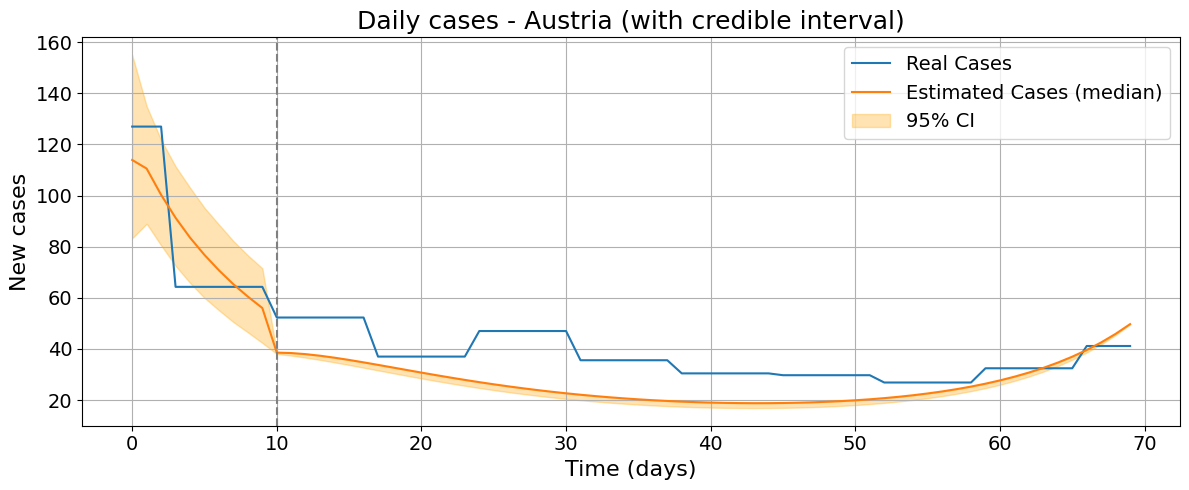

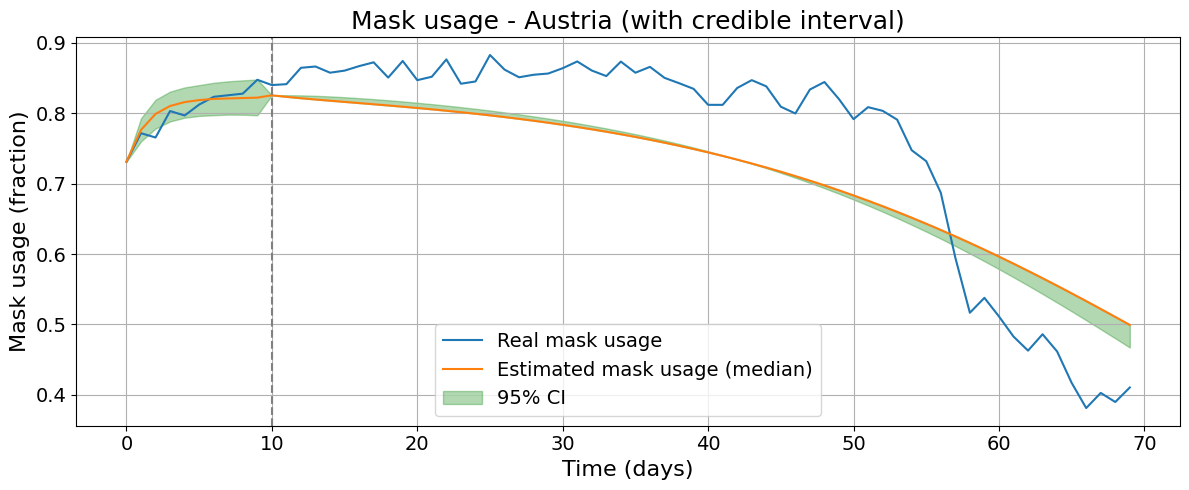

In [2]:
# --- BLOCCO 2 ---
ll2 = make_log_likelihood(daily_cases_2, mask_2, CHI_2)
def log_post2(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp): return -np.inf
    ll = ll2(theta)
    return -np.inf if not np.isfinite(ll) else lp + ll

trace2, logp2 = metropolis(start2, log_post2, n_iter=n_iter, proposal_scales=proposal_scales, seed=2)
df_trace2 = pd.DataFrame(trace2, columns=param_names)
samples2 = df_trace2[int(n_iter/2):].copy().reset_index(drop=True)
med2 = samples2.median().to_dict()
params_median2 = {k: med2[k] for k in param_names}
params_median2.update({'gamma':1/10,'delta':1/180,'epsilon':1/5,'CHI':CHI_2,'mask0':float(mask_2[0])})
y_finale1_state = y_finale1  # proveniente da simulazione precedente
y_finale2, y0_2, casi_stimati2, mask_stimati2 = simulate_model_numeric(params_median2, ini=y_finale1_state)
eo2 = compute_E0(0, y0_2, params_median2)
print("E0 (blocco 2) =", eo2)

#plotto mediana dei valori dei paramteri, voglio mediana ogni t
daily_cases_combined = np.concatenate([daily_cases_1, daily_cases_2])
#casi_stimati_all = np.concatenate([casi_stimati1, casi_stimati2])
mask_combined = np.concatenate([mask_1, mask_2])
#mask_stimati_all = np.concatenate([mask_stimati1, mask_stimati2])'''

# BLOCCO2
cases_matrix2, mask_matrix2 = simulate_all_samples(samples2, CHI_2, mask_2, ini_state=y_finale1_state)
mask_median2 = np.median(mask_matrix2, axis=0)
mask_ci_lower2 = np.percentile(mask_matrix2, 2.5, axis=0)
mask_ci_upper2 = np.percentile(mask_matrix2, 97.5, axis=0)
cases_median2 = np.median(cases_matrix2, axis=0)
cases_ci_lower2 = np.percentile(cases_matrix2, 2.5, axis=0)
cases_ci_upper2 = np.percentile(cases_matrix2, 97.5, axis=0)

# 1+2 UNIONE
mask_median_all = np.concatenate([mask_median1, mask_median2])
mask_ci_lower_all = np.concatenate([mask_ci_lower1, mask_ci_lower2])
mask_ci_upper_all = np.concatenate([mask_ci_upper1, mask_ci_upper2])

cases_median_all = np.concatenate([cases_median1, cases_median2])
cases_ci_lower_all = np.concatenate([cases_ci_lower1, cases_ci_lower2])
cases_ci_upper_all = np.concatenate([cases_ci_upper1, cases_ci_upper2])

# Figura 1: Daily cases
plt.figure(figsize=(12,5))
plt.plot(daily_cases_combined * N, label="Real Cases")
plt.plot(cases_median_all * N, label="Estimated Cases (median)")
plt.fill_between(range(len(cases_median_all)), cases_ci_lower_all * N, cases_ci_upper_all * N, color='orange', alpha=0.3, label="95% CI")
plt.axvline(x=T_split1, color='gray', linestyle='--')
plt.legend(fontsize=14)
plt.xlabel("Time (days)", fontsize=16)
plt.ylabel("New cases", fontsize=16)
plt.title(f"Daily cases - {country} (with credible interval)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig(f"C:\\Users\\user\\Desktop\\immaginitt\\parte3immagini\\fiitng\\daily_cases_{country}.png")  # salva immagine
plt.show()

# Figura 2: Mask usage
plt.figure(figsize=(12,5))
plt.plot(mask_combined, label="Real mask usage")
plt.plot(mask_median_all, label="Estimated mask usage (median)")
plt.fill_between(range(len(mask_median_all)), mask_ci_lower_all, mask_ci_upper_all, color='green', alpha=0.3, label="95% CI")
plt.axvline(x=T_split1, color='gray', linestyle='--')
plt.legend(fontsize=14)
plt.xlabel("Time (days)", fontsize=16)
plt.ylabel("Mask usage (fraction)", fontsize=16)
plt.title(f"Mask usage - {country} (with credible interval)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig(f"C:\\Users\\user\\Desktop\\immaginitt\\parte3immagini\\fiitng\\mask_usage_{country}.png")  # salva immagine
plt.show()


In [9]:
print(params_median1)
print(params_median2)

{'beta': 0.34254955036290247, 'rho': 0.11436241783230672, 'phi': 0.39047256767947786, 'k1': 0.478903533218142, 'k2': 0.4940856160281171, 'l1': 0.1474045690004032, 'l2': 0.11697406461112433, 'k3': 0.5256095736064712, 'k4': 0.4910088497452562, 'k5': 0.4922201135678007, 'k6': 0.5071653769161072, 'l3': 0.08939785284349189, 'l4': 0.10924550844866, 'l5': 0.07846637830361769, 'l6': 0.06806993376181848, 'gamma': 0.1, 'delta': 0.005555555555555556, 'epsilon': 0.2, 'CHI': array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]), 'mask0': 0.7310924369747899}
{'beta': 0.34026685952411573, 'rho': 0.015996348223214416, 'phi': 0.5380467065632566, 'k1': 0.16076101933812562, 'k2': 0.37012868751634254, 'l1': 0.05257707480530002, 'l2': 0.0003387052893660822, 'k3': 0.017154535592801667, 'k4': 0.6033008417493593, 'k5': 0.47848316809409, 'k6': 0.5019930506311316, 'l3': 0.017013807517658446, 'l4': 0.006785618439733252, 'l5': 0.07871109634207575, 'l6': 0.004902016180714847, 'gamma': 0.1, 'delta': 0.005555555555555556,

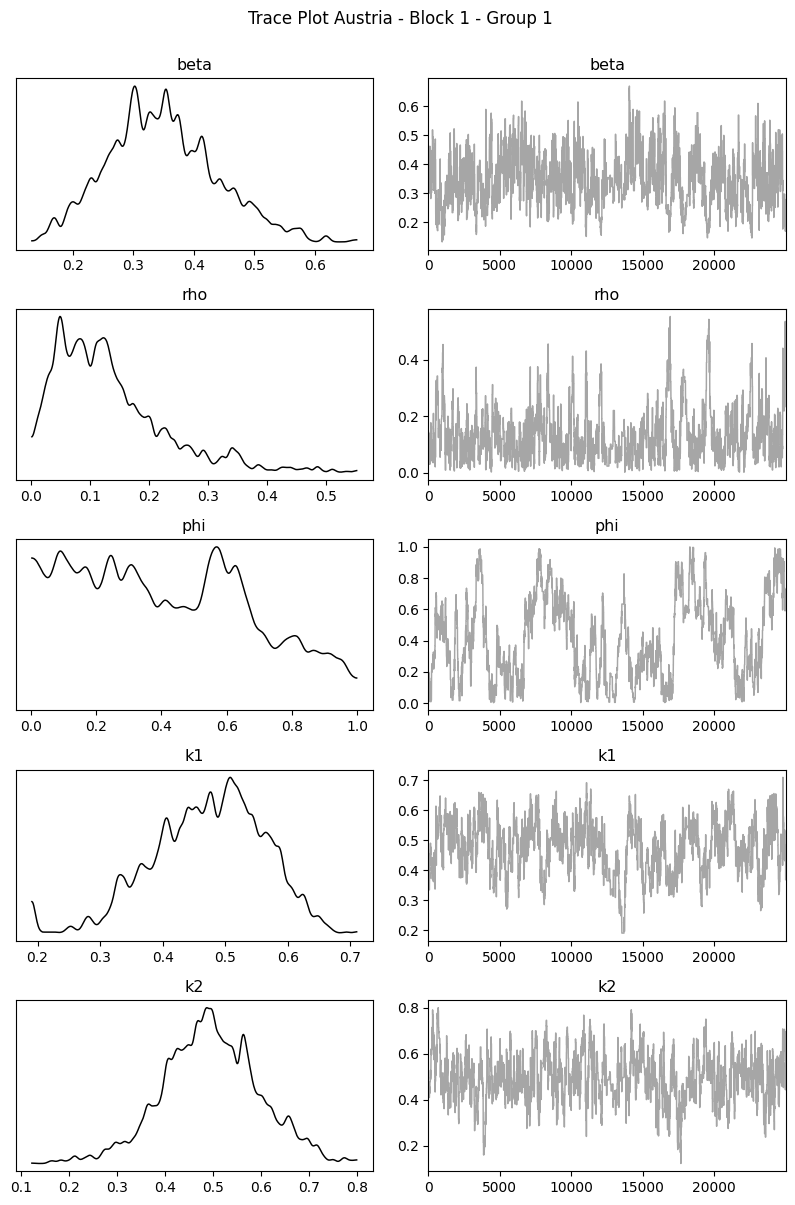

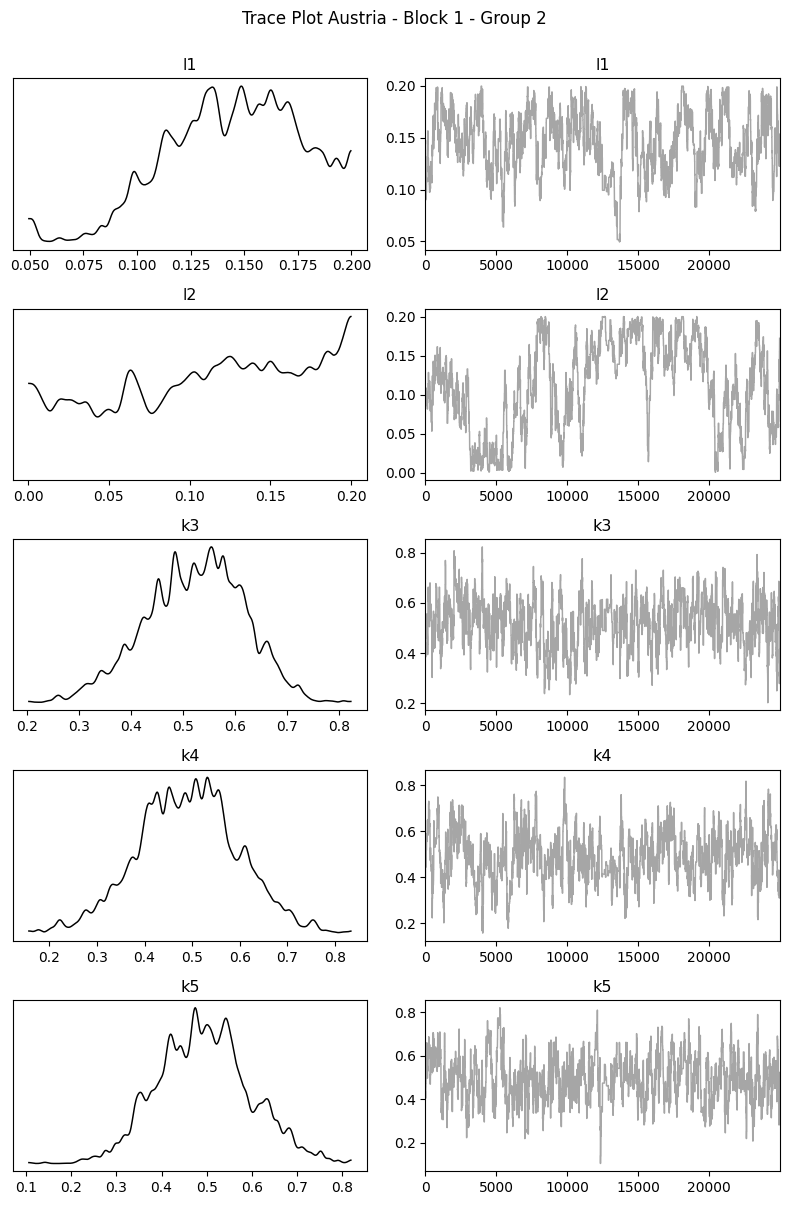

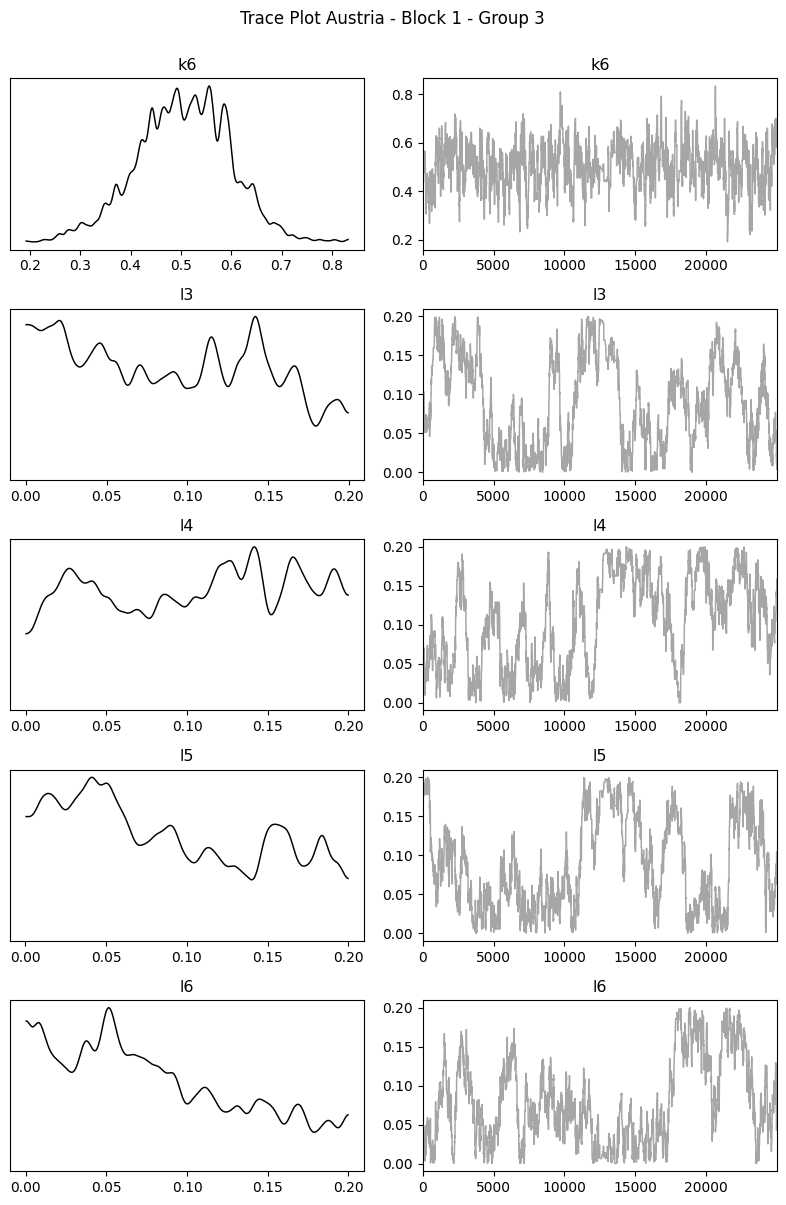

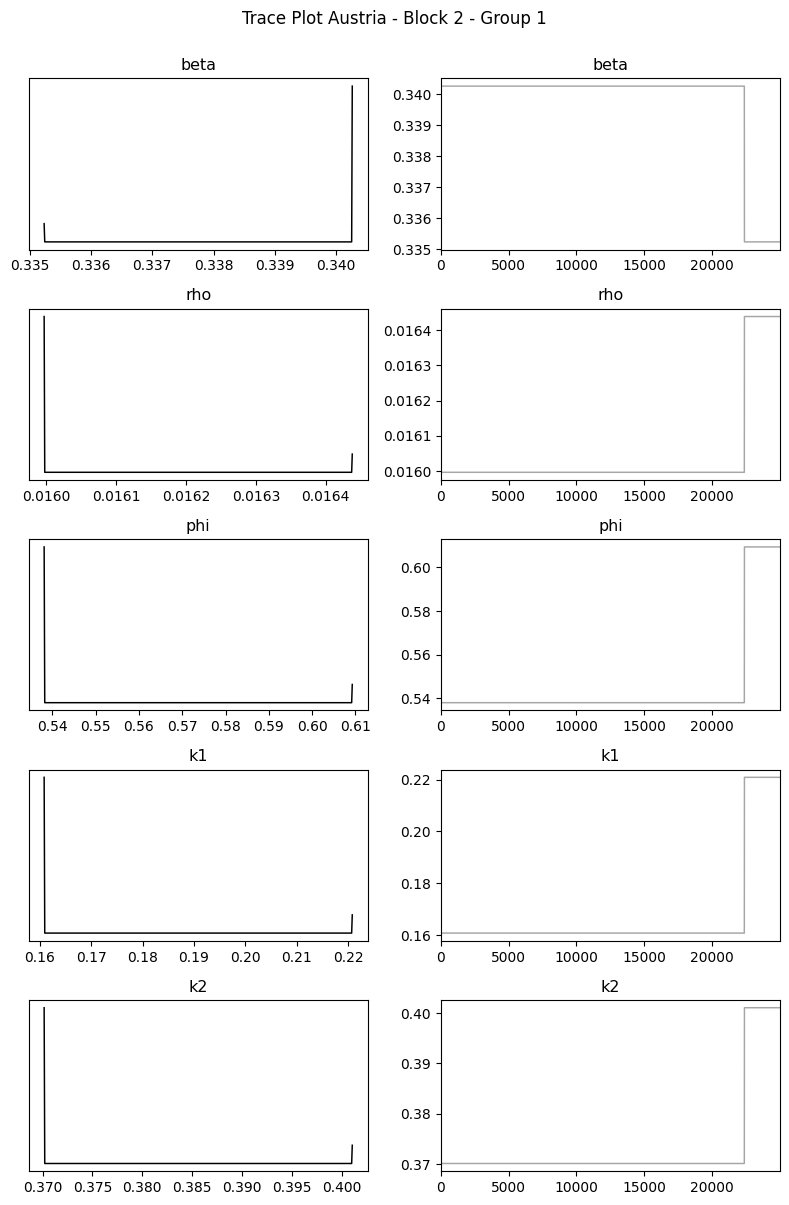

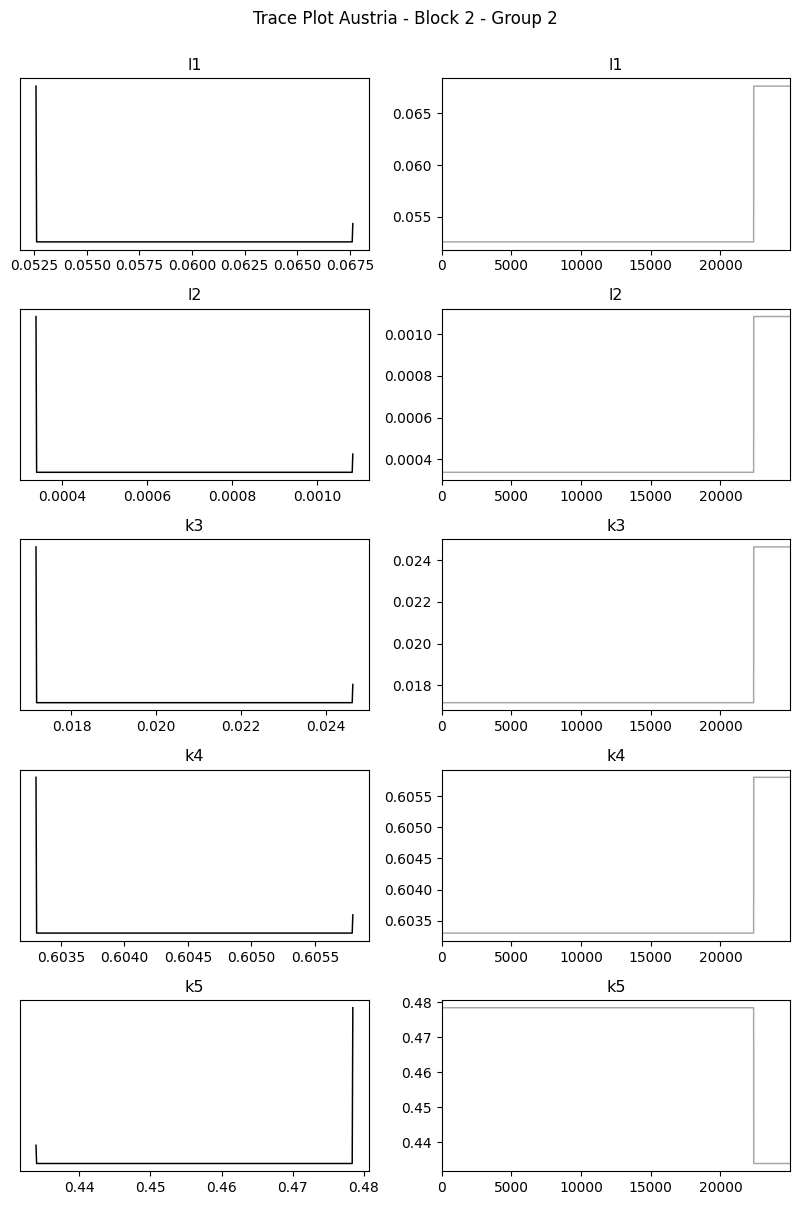

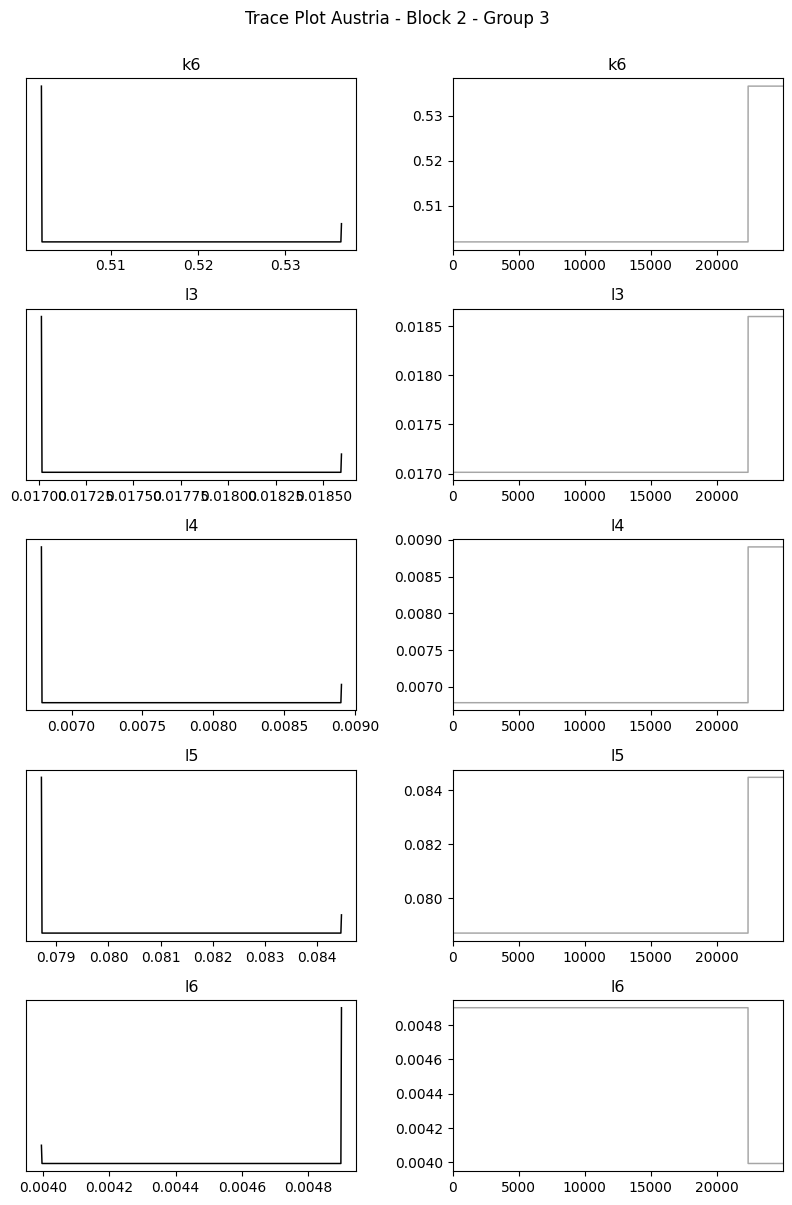

In [10]:
import arviz as az
import matplotlib.pyplot as plt

# param_names è la lista di tutti i parametri
n_params_per_plot = 5  # quanti parametri vuoi in ogni immagine
param_groups = [param_names[i:i+n_params_per_plot] for i in range(0, len(param_names), n_params_per_plot)]

for i, group in enumerate(param_groups):
    posterior_dict_group = {k: samples1[k].values.reshape((1, -1)) for k in group}
    idata_group = az.from_dict(posterior=posterior_dict_group)
    
    # trace plot con linee nere
    axes = az.plot_trace(idata_group, kind='trace', compact=True, figsize=(8, 12))  # compact riduce gli spazi vuoti
    
    # cambiare tutte le linee in nero
    for ax_row in axes:
        for ax in ax_row:
            for line in ax.get_lines():
                line.set_color('black')  # imposta colore nero
    
    plt.suptitle(f"Trace Plot {country} - Block 1 - Group {i+1}", y=1)
    plt.tight_layout()
    plt.savefig(f"C:\\Users\\user\\Desktop\\immaginitt\\parte3immagini\\fiitng\\block1_{country}_group{i+1}.png")
    plt.show()



# param_names è la lista di tutti i parametri
param_groups = [param_names[i:i+n_params_per_plot] for i in range(0, len(param_names), n_params_per_plot)]

for i, group in enumerate(param_groups):
    posterior_dict_group = {k: samples2[k].values.reshape((1, -1)) for k in group}
    idata_group = az.from_dict(posterior=posterior_dict_group)
    
    # trace plot con linee nere
    axes = az.plot_trace(idata_group, kind='trace', compact=True, figsize=(8, 12))  # compact riduce gli spazi vuoti
    
    # cambiare tutte le linee in nero
    for ax_row in axes:
        for ax in ax_row:
            for line in ax.get_lines():
                line.set_color('black')  # imposta colore nero
    
    plt.suptitle(f"Trace Plot {country} - Block 2 - Group {i+1}", y=1)
    plt.tight_layout()
    plt.savefig(f"C:\\Users\\user\\Desktop\\immaginitt\\parte3immagini\\fiitng\\block2_{country}_group{i+1}.png")
    plt.show()


In [11]:
def valuta_fit(observed, predicted):
    n = len(observed)
    # RMSE (Root Mean Square Error)
    rmse = np.sqrt(np.mean((observed - predicted)**2))
    print("RMSE:", rmse)
    # MAE (Mean Absolute Error)
    mae = np.mean(np.abs(observed - predicted))
    print("MAE:", mae)
    # R-squared
    ss_res = np.sum((observed - predicted)**2)
    ss_tot = np.sum((observed - np.mean(observed))**2)
    r_squared = 1 - (ss_res / ss_tot) 
    print("R_squared:", r_squared)
    # MAPE (Mean Absolute Percentage Error) - solo per valori positivi
    if np.all(observed > 0):
        mape = np.mean(np.abs((observed - predicted) / observed)) * 100
    else:
        mape = np.nan
    print("MAPE:", mape)
    return {"RMSE": rmse, "MAE": mae, "R_squared": r_squared, "MAPE": mape}


# --- BLOCCO 1 ---
print("=== Valutazione fit Blocco 1 ===")
print("\nCasi:")
metrics_cases1 = valuta_fit(daily_cases_1, casi_stimati1)
print("\nMascherina:")
metrics_mask1 = valuta_fit(mask_1, mask_stimati1)

# --- BLOCCO 2 ---
print("\n=== Valutazione fit Blocco 2 ===")
print("\nCasi:")
metrics_cases2 = valuta_fit(daily_cases_2, casi_stimati2)
print("\nMascherina:")
metrics_mask2 = valuta_fit(mask_2, mask_stimati2)


=== Valutazione fit Blocco 1 ===

Casi:
RMSE: 1.7651541383706814e-06
MAE: 1.4935401795217197e-06
R_squared: 0.6944361373818344
MAPE: 16.59789556118475

Mascherina:
RMSE: 0.015119161885137749
MAE: 0.010552963713693918
R_squared: 0.7950029458626804
MAPE: 1.3222361962620361

=== Valutazione fit Blocco 2 ===

Casi:
RMSE: 1.3588378327062273e-06
MAE: 1.166908470660943e-06
R_squared: -1.2693200922013208
MAPE: 27.803477646367025

Mascherina:
RMSE: 0.08946311160203883
MAE: 0.08340401435715075
R_squared: 0.684900477805402
MAPE: 12.269342018762964


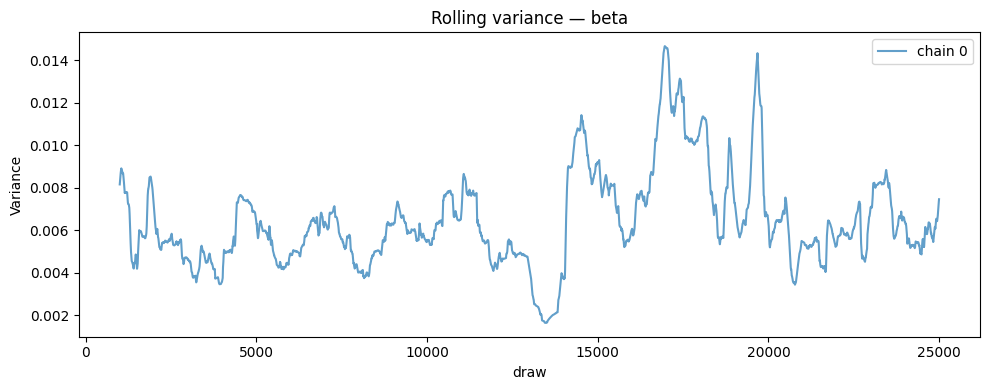

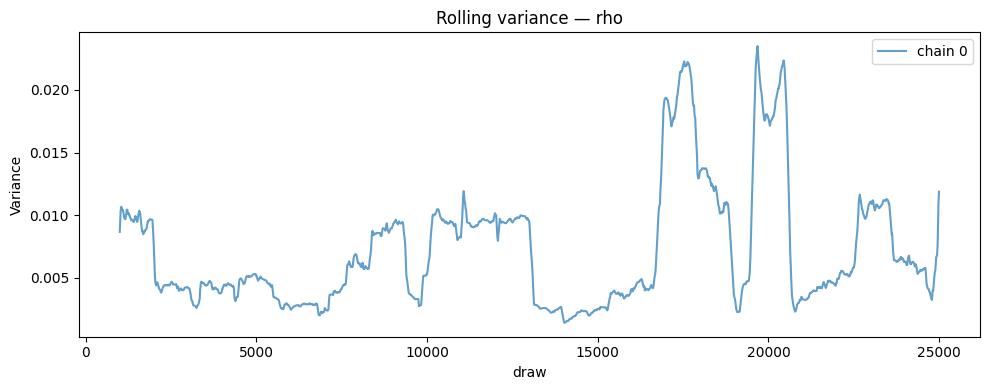

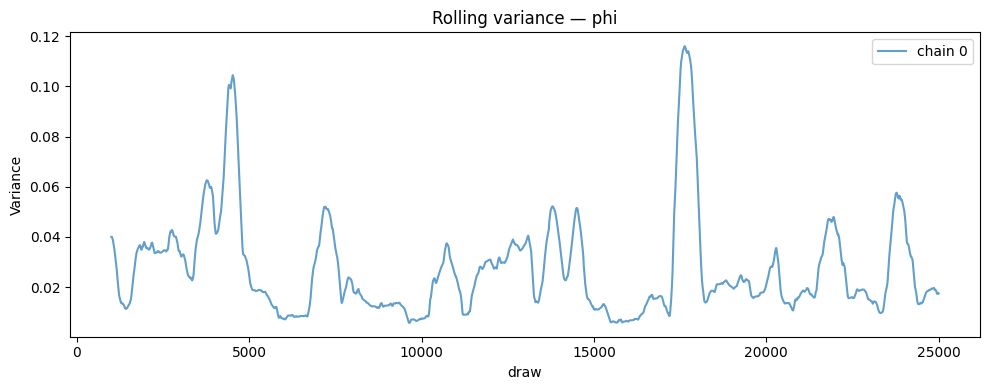

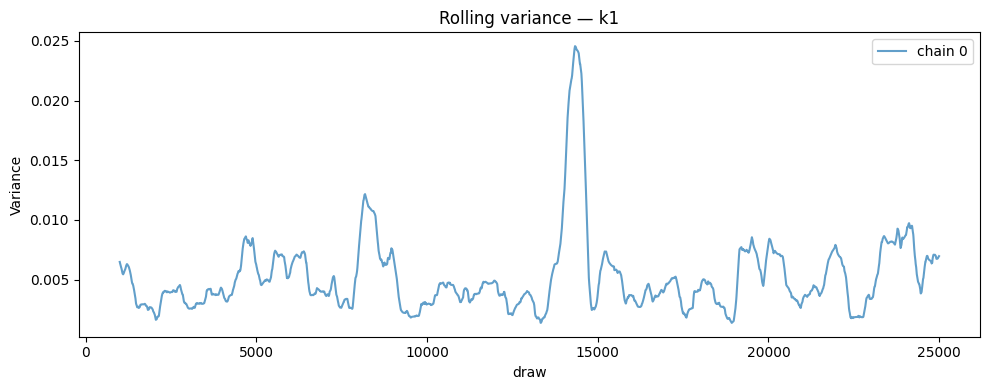

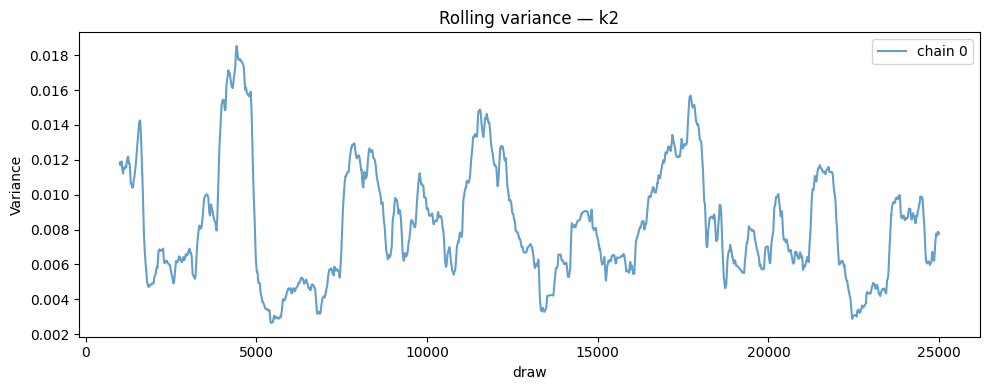

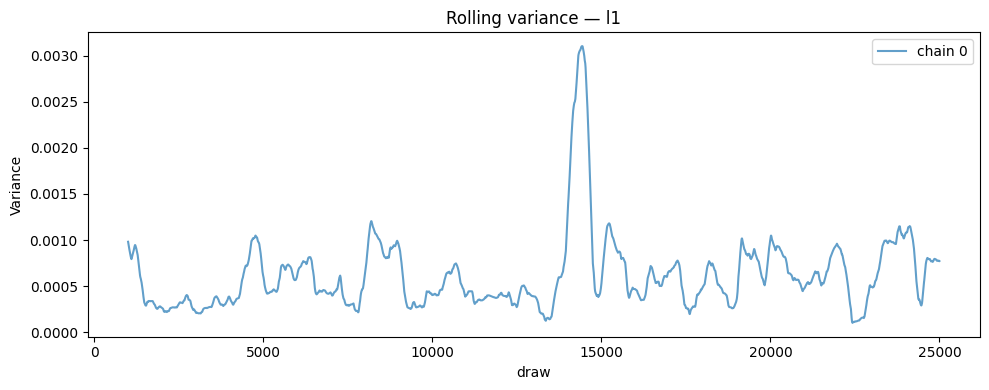

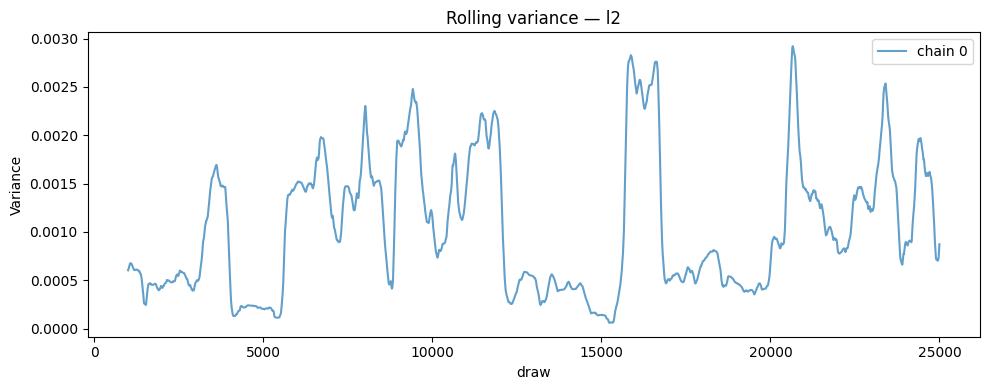

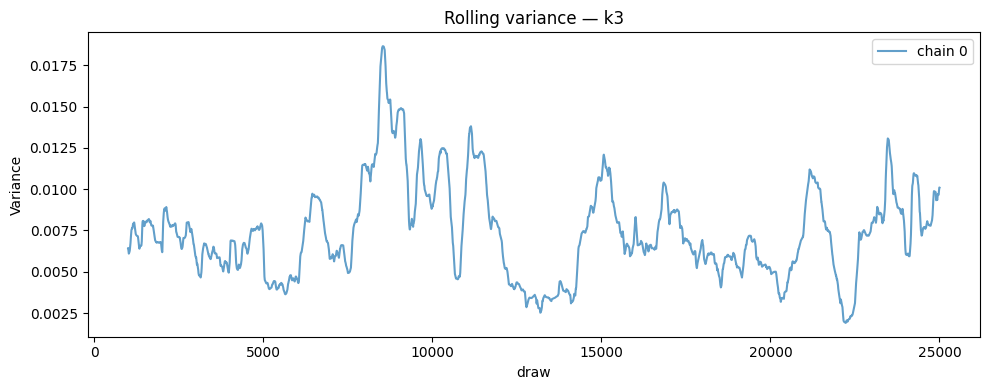

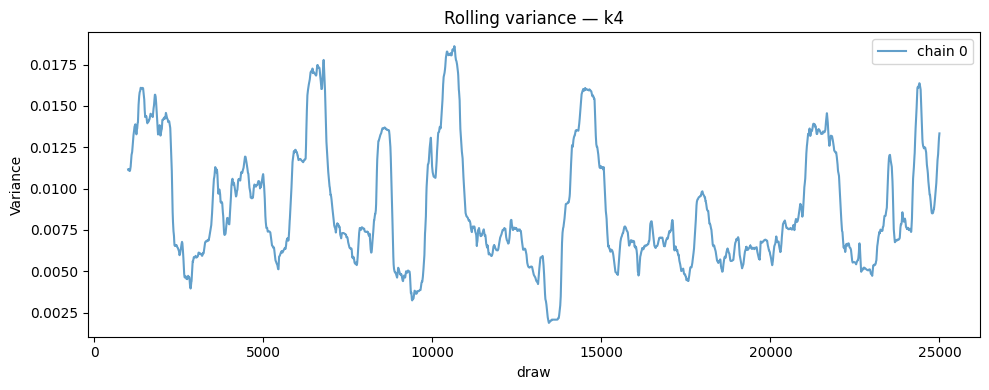

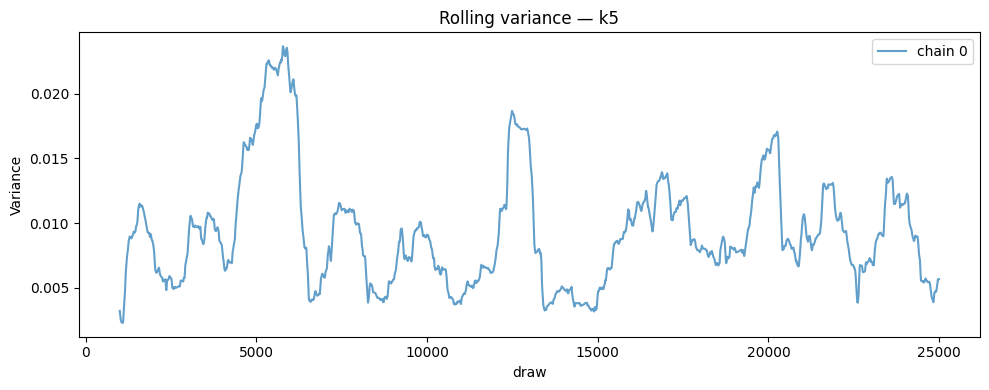

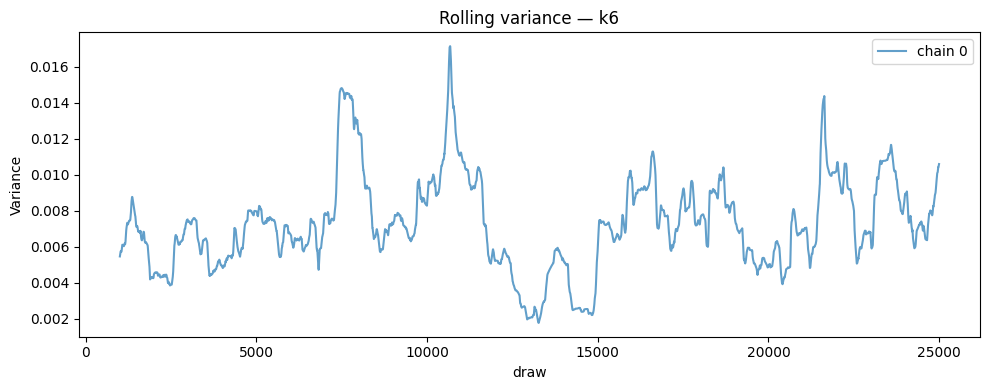

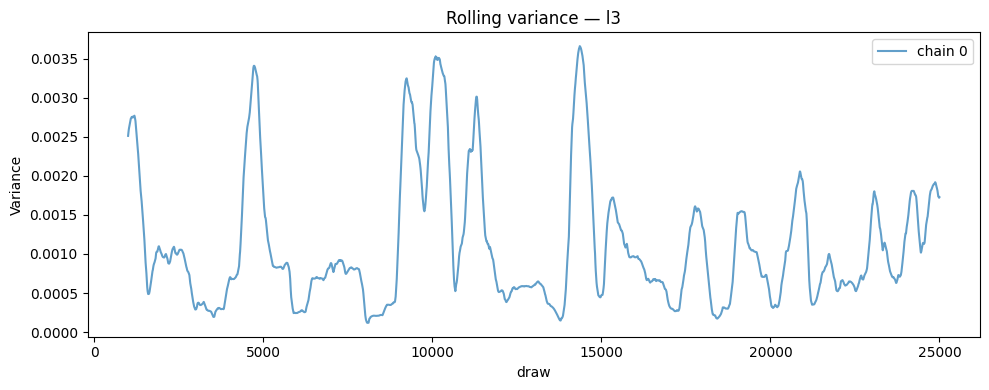

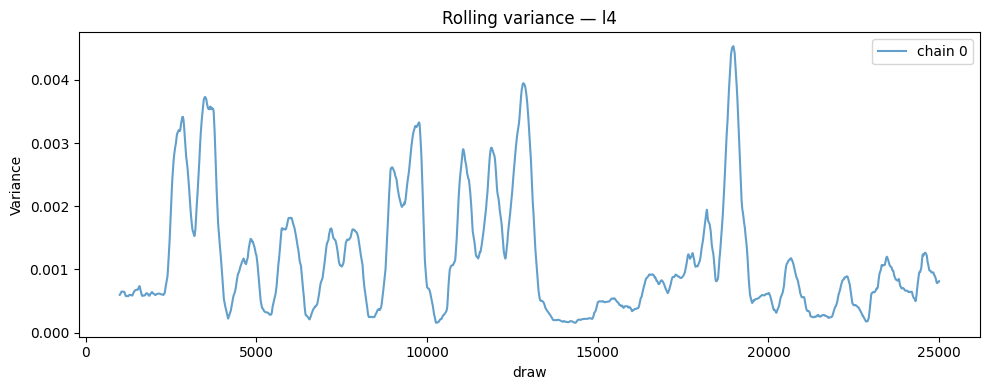

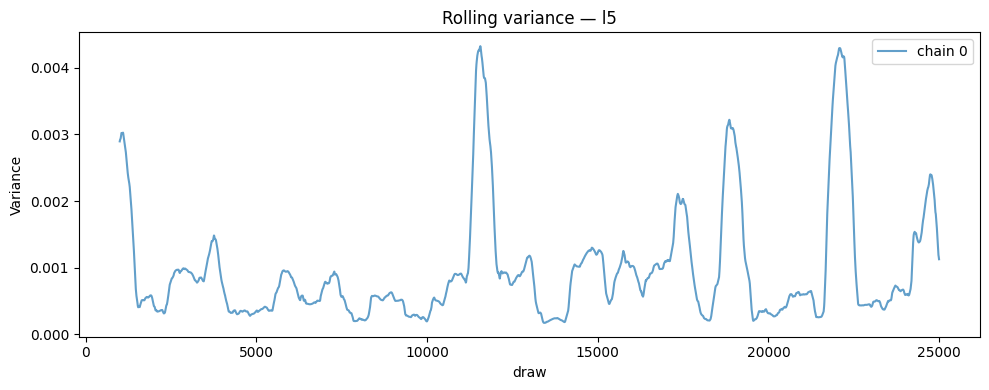

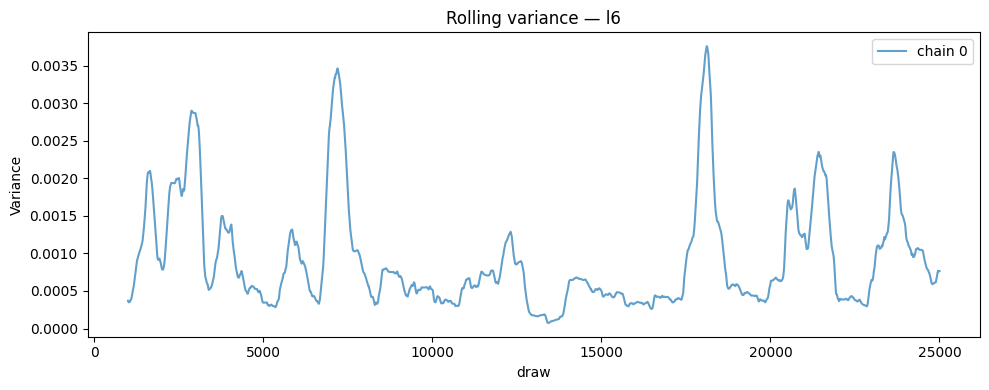

In [12]:
import arviz as az
#blocco 1
posterior_dict1 = {k: samples1[k].values.reshape((1, -1)) for k in param_names}
idata1 = az.from_dict(posterior=posterior_dict1)

posterior = idata1.posterior
beta = posterior["beta"]  # dims: (chain, draw)

# Compute rolling variance along the "draw" dimension
rolling_var = beta.rolling(draw=1000).var()

posterior_all = idata1.posterior  # xarray.Dataset

# Rolling variance along draws for ALL variables in the posterior
rolling_var_all = posterior_all.rolling(draw=1000).var()

for var_name, da in rolling_var_all.data_vars.items():  # <-- returns (name, DataArray)
    plt.figure(figsize=(10, 4))

    # choose plotting behavior depending on whether 'chain' exists
    if "chain" in da.dims:
        n_chains = da.sizes["chain"]
        x_dim = "draw" if "draw" in da.dims else da.dims[-1]
        for c in range(n_chains):
            series = da.isel(chain=c)
            series.plot(x=x_dim, label=f"chain {c}", alpha=0.7)
    else:
        # combined/stacked case (e.g. 'sample' dim) or single-chain
        x_dim = "draw" if "draw" in da.dims else ("sample" if "sample" in da.dims else da.dims[-1])
        da.plot(x=x_dim)

    plt.title(f"Rolling variance — {var_name}")
    plt.xlabel(x_dim)
    plt.ylabel("Variance")
    plt.legend()
    plt.tight_layout()
    plt.show()

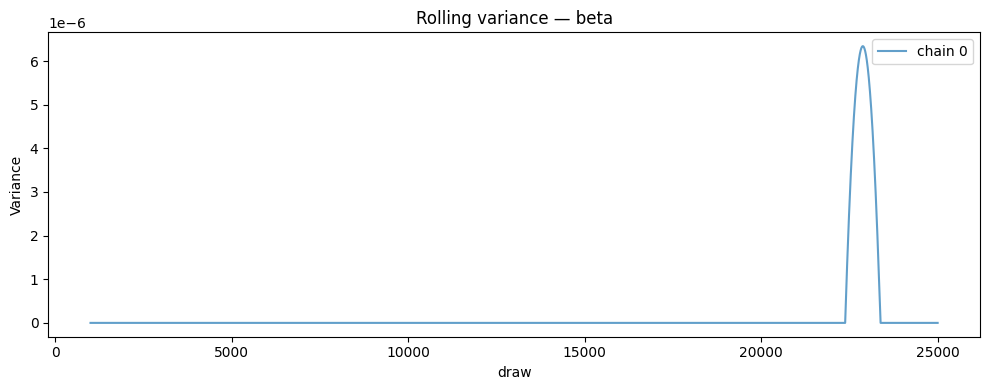

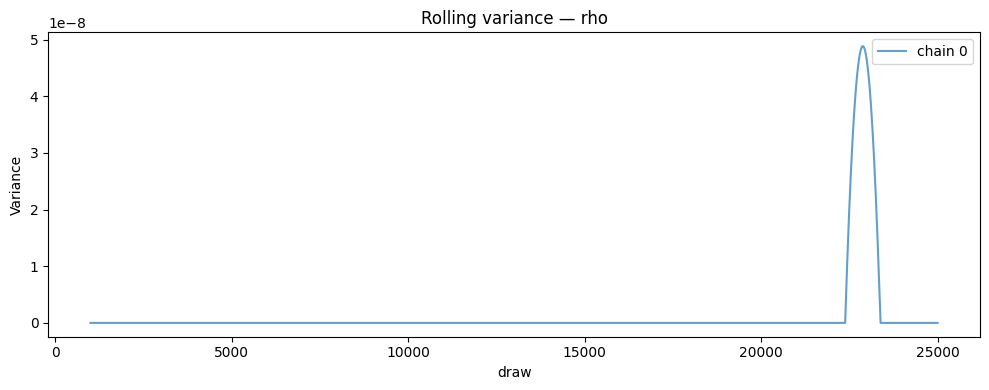

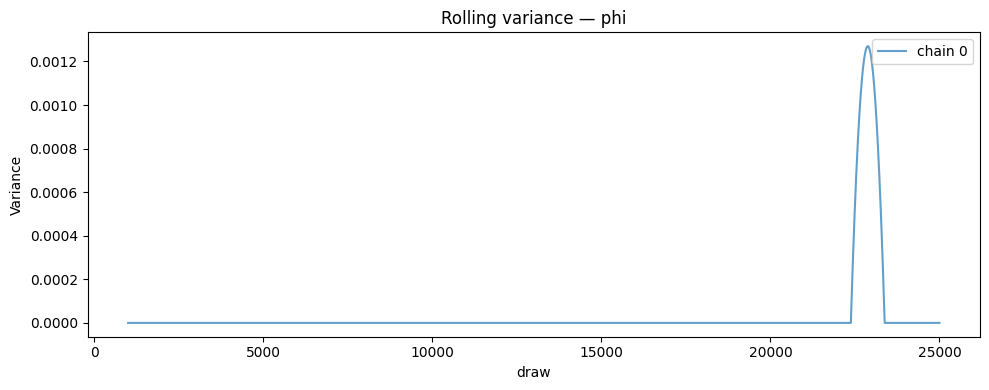

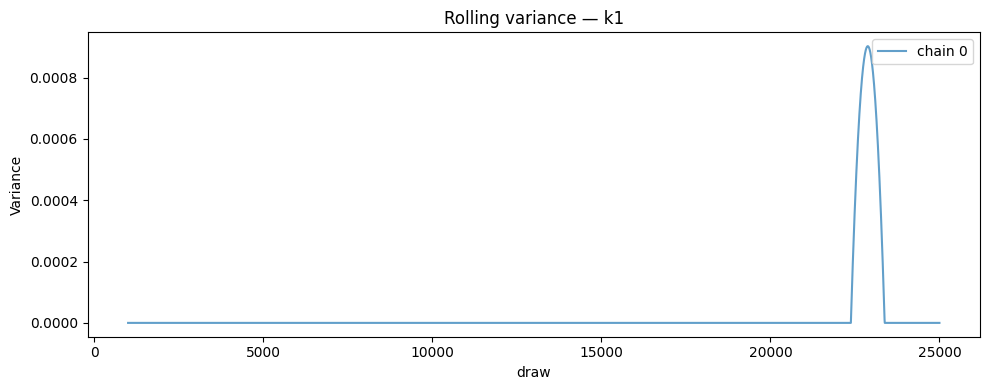

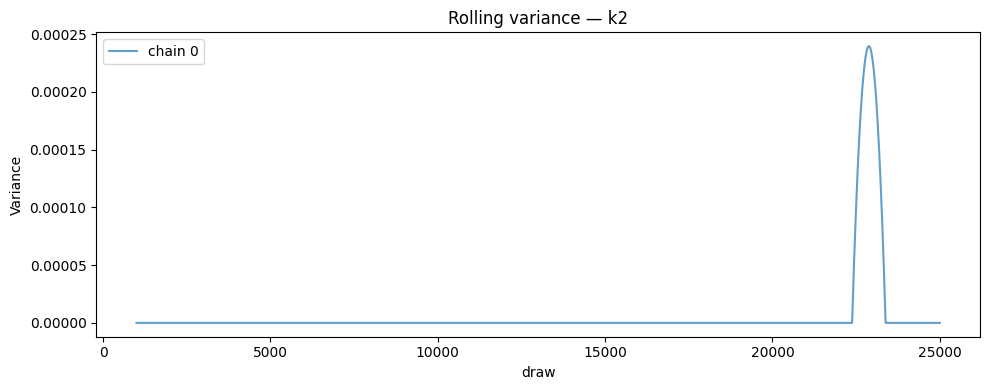

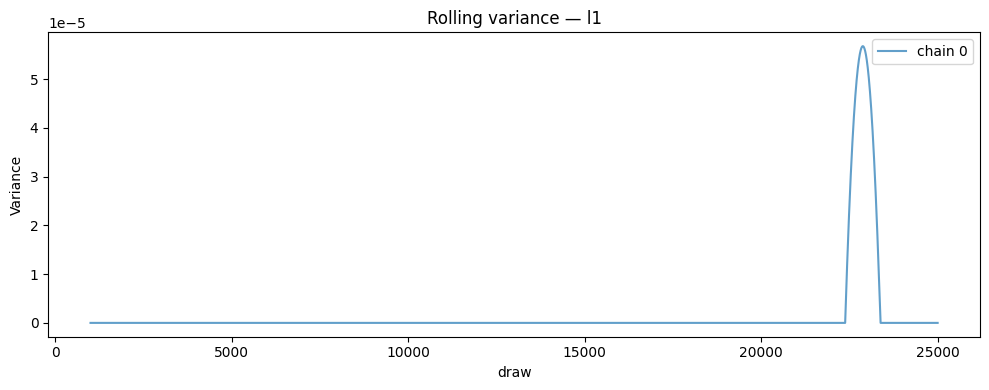

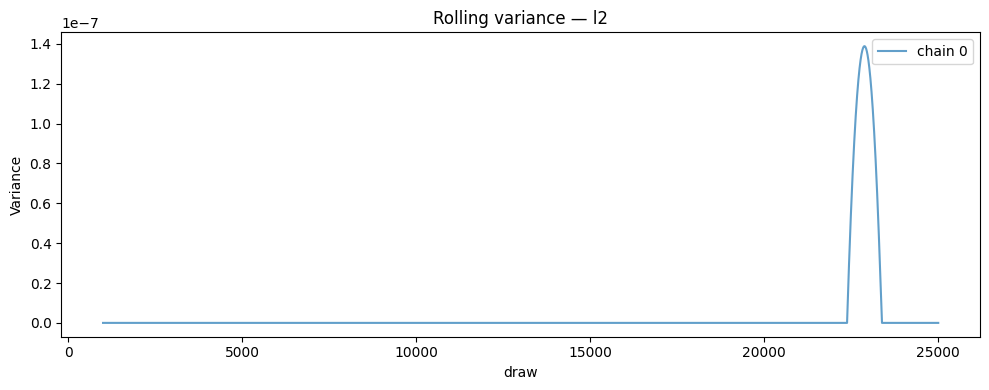

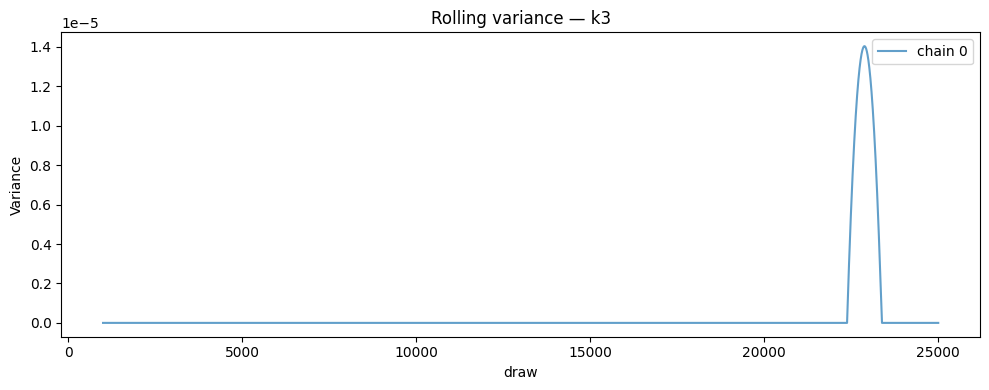

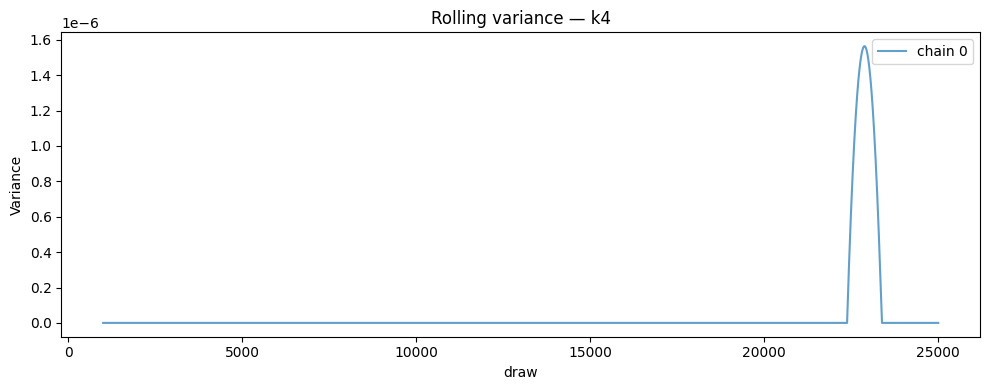

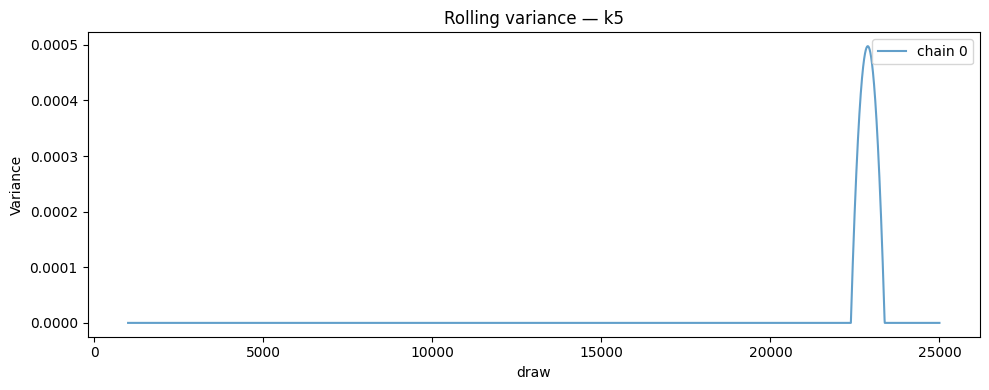

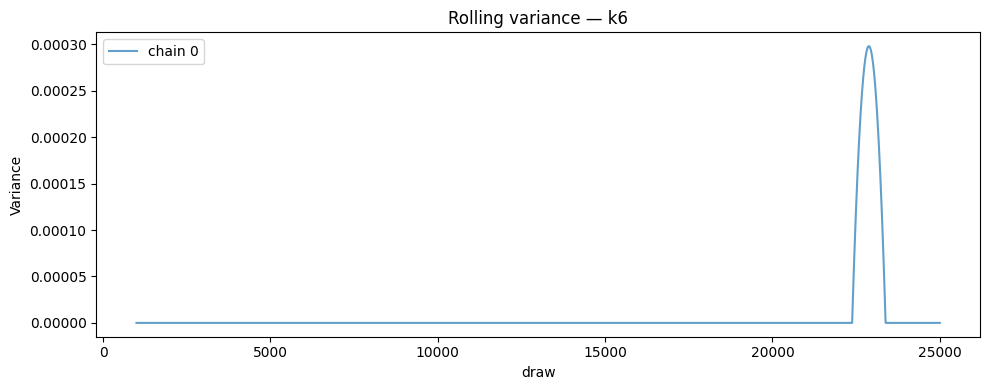

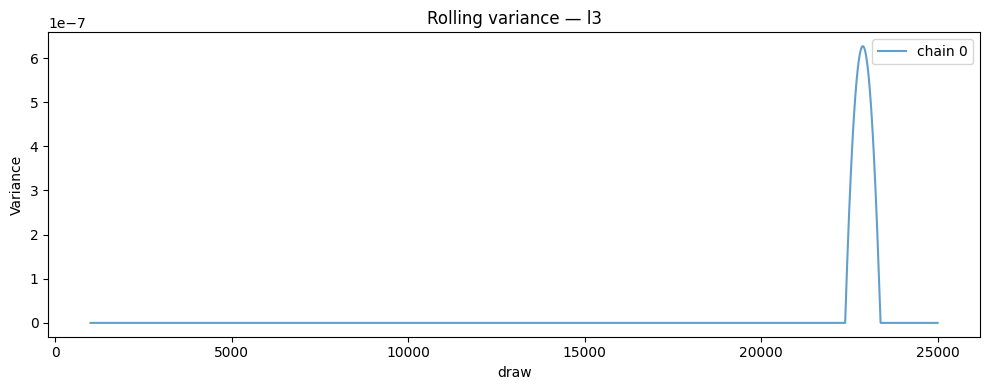

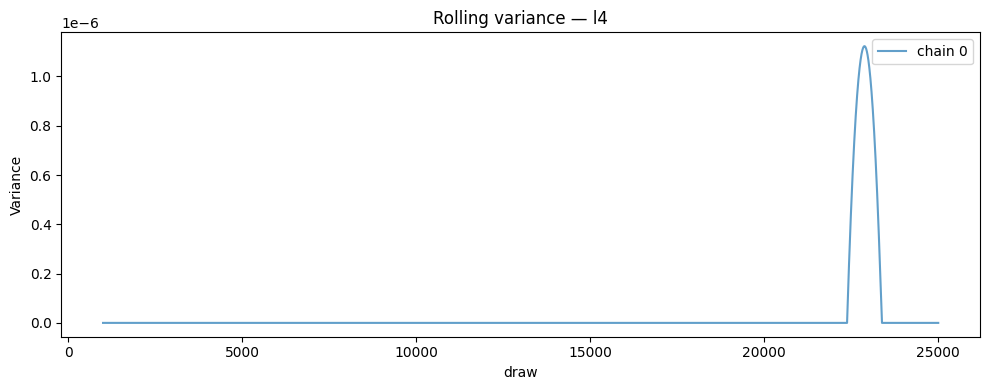

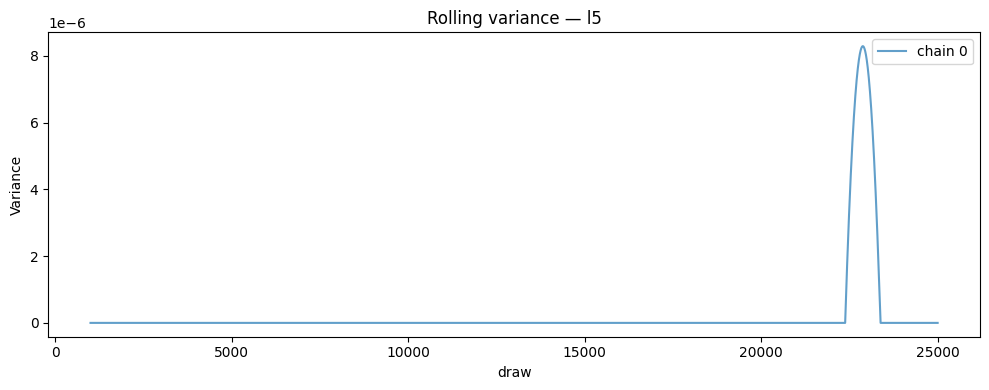

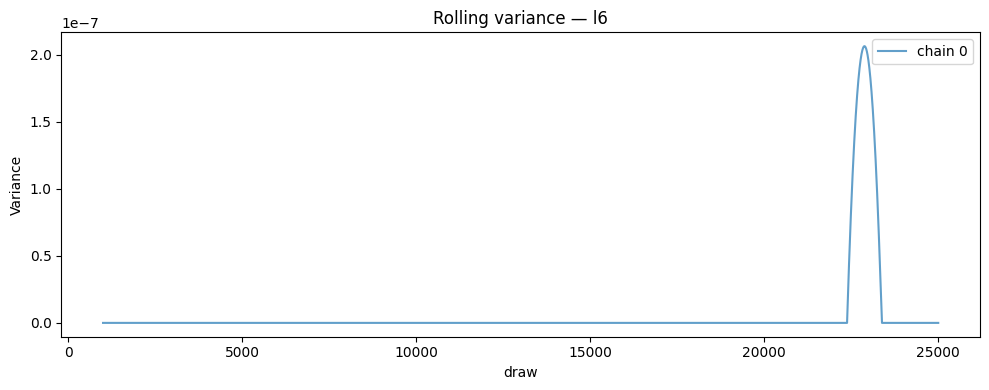

In [13]:
#blocco2
posterior_dict2 = {k: samples2[k].values.reshape((1, -1)) for k in param_names}
idata2 = az.from_dict(posterior=posterior_dict2)

posterior = idata2.posterior
beta = posterior["beta"]  # dims: (chain, draw)

# Compute rolling variance along the "draw" dimension
rolling_var = beta.rolling(draw=1000).var()

posterior_all = idata2.posterior  # xarray.Dataset

# Rolling variance along draws for ALL variables in the posterior
rolling_var_all = posterior_all.rolling(draw=1000).var()

for var_name, da in rolling_var_all.data_vars.items():  # <-- returns (name, DataArray)
    plt.figure(figsize=(10, 4))

    # choose plotting behavior depending on whether 'chain' exists
    if "chain" in da.dims:
        n_chains = da.sizes["chain"]
        x_dim = "draw" if "draw" in da.dims else da.dims[-1]
        for c in range(n_chains):
            series = da.isel(chain=c)
            series.plot(x=x_dim, label=f"chain {c}", alpha=0.7)
    else:
        # combined/stacked case (e.g. 'sample' dim) or single-chain
        x_dim = "draw" if "draw" in da.dims else ("sample" if "sample" in da.dims else da.dims[-1])
        da.plot(x=x_dim)

    plt.title(f"Rolling variance — {var_name}")
    plt.xlabel(x_dim)
    plt.ylabel("Variance")
    plt.legend()
    plt.tight_layout()
    plt.show()